In [49]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from typing import Union
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import joblib
%matplotlib inline

In [2]:
df = pd.read_csv('AusAntidiabeticDrug.csv')

In [3]:
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


In [5]:
df.describe()

,y
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


In [6]:
df.shape

(204, 2)

## EDA

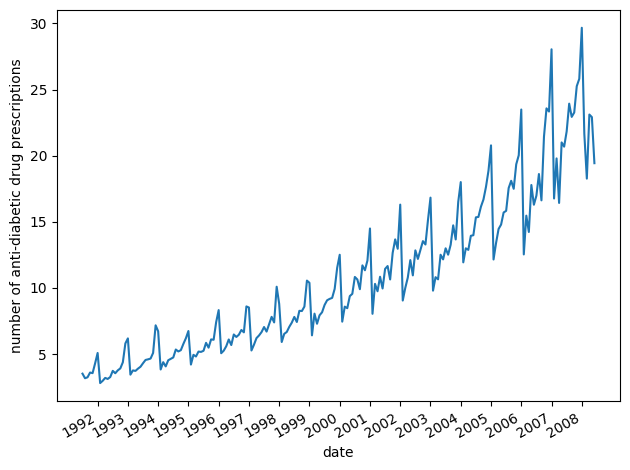

In [7]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('date')
ax.set_ylabel('number of anti-diabetic drug prescriptions')
plt.xticks(np.arange(6,203,12), np.arange(1992,2009,1))

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
decomposition = STL(df.y, period=12).fit()

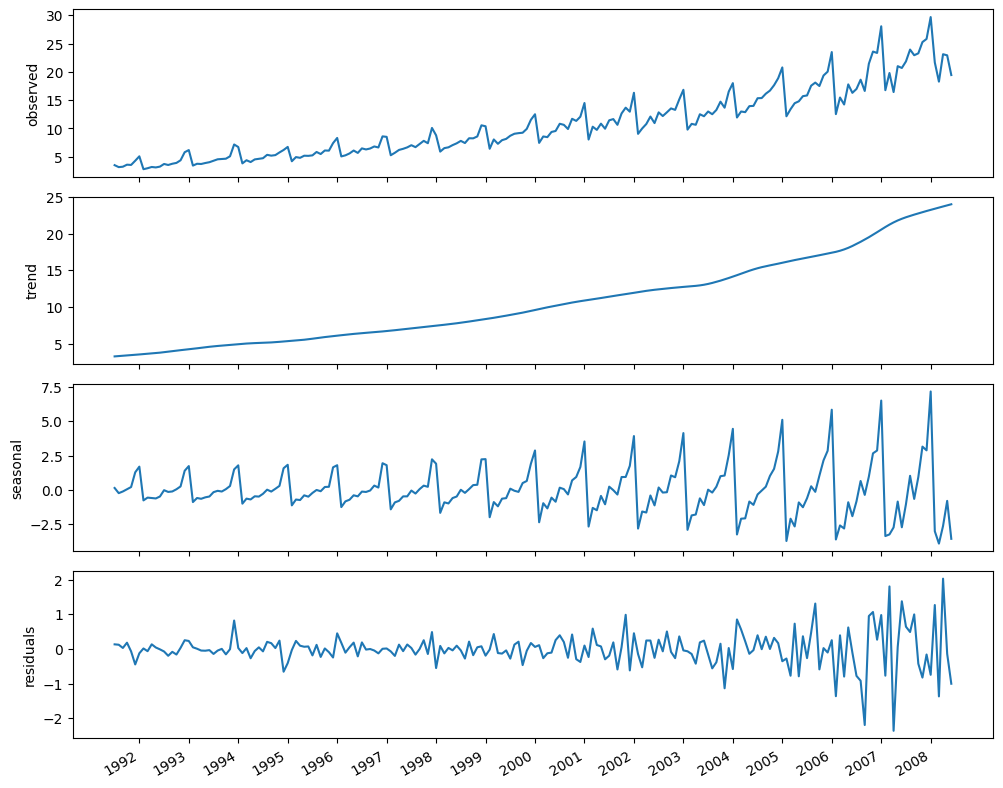

In [9]:
'''
data has trend, seasonality
'''
fig, (ax1,ax2,ax3,ax4) =  plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('residuals')

plt.xticks(np.arange(6,203,12), np.arange(1992,2009,1))
fig.autofmt_xdate()
plt.tight_layout()

In [10]:
# stationary check, we will use SARIMA model, unable to reject null hypothesis, time series is non-stationary
ad_fuller_result = adfuller(df.y)

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF statistic: 3.1451856893067354
p-value: 1.0


In [11]:
# first order differenciation , unable to reject null hypothesis, time series is non-stationary
y_diff = np.diff(df.y, n=1)

ad_fuller_result = adfuller(y_diff)

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF statistic: -2.495172147449657
p-value: 0.11665341686470798


In [12]:
# p-value is less than 0.05, then reject null hypothesis that is time series is non-stationary, so we assume stationary time series.
y_diff_seasonal = np.diff(y_diff, n=12)

ad_fuller_result = adfuller(y_diff_seasonal)

print(f'ADF statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF statistic: -19.848440096900926
p-value: 0.0


In [13]:
# d=1, D=1, train test split 
train = df.y[:168]
test = df.y[168:]

In [14]:
train.shape, test.shape

((168,), (36,))

In [15]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results=[]

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0],d,order[1]),
                seasonal_order=(order[2],D,order[3],s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)','AIC']

    # assending order, the lower aic, the better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [16]:
ps=range(0,5,1)
qs=range(0,5,1)
Ps=range(0,5,1)
Qs=range(0,5,1)

order_list = list(product(ps,qs,Ps,Qs))

# difference
d = 1
# diff
D = 1
# seasonality
s= 12

In [ ]:
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d,D,s)
SARIMA_result_df

In [17]:
# (p,q,P,Q)	AIC
# 0	(3, 1, 1, 3)	270.951096

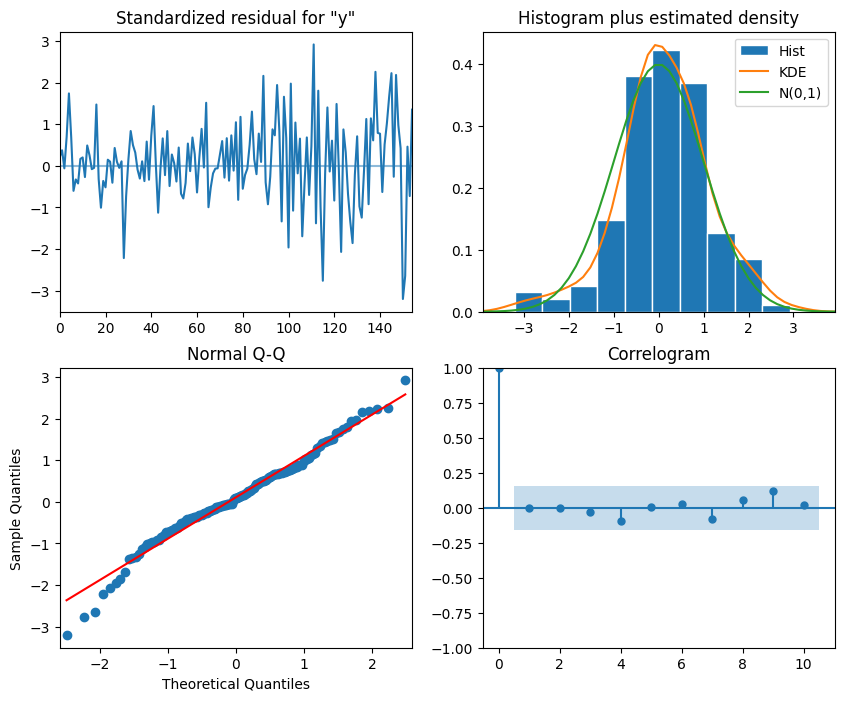

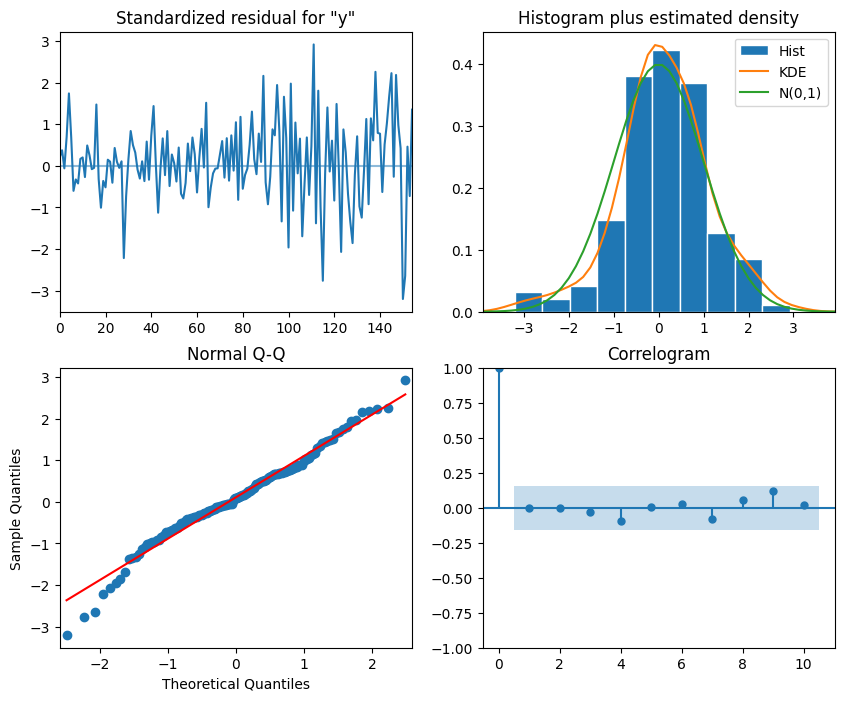

In [18]:
# residual analysis
SARIMA_model = SARIMAX(train, order=(3,1,1),
                       seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [50]:
joblib.dump(SARIMA_model_fit, 'SARIMA_MODEL.joblib')

['SARIMA_MODEL.joblib']

In [19]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

lb_pvalue


In [20]:
# evaluate model
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season =[]
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA =[]
        for i in range(train_len,total_len, window):
            model = SARIMAX(df['y'][:i], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA

In [21]:
pred_df = df[168:]

In [23]:
pred_df.shape

(36, 2)

In [24]:
TRAIN_LEN=168
HORIZON=36
WINDOW=12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

/var/folders/8m/jbl92pvn45zg5k2bbfx4ff840000gn/T/ipykernel_95354/1575766810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')


In [25]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

/var/folders/8m/jbl92pvn45zg5k2bbfx4ff840000gn/T/ipykernel_95354/2584904577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')


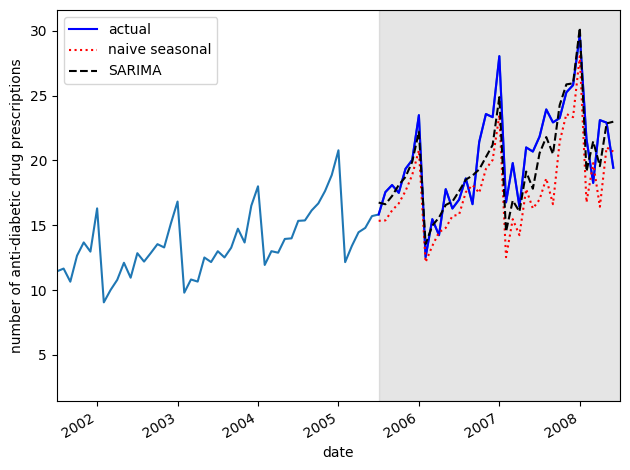

In [39]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('date')
ax.set_ylabel('number of anti-diabetic drug prescriptions')
ax.axvspan(168,204,color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6,203,12), np.arange(1992,2009,1))
plt.xlim(120,204)

fig.autofmt_xdate()
plt.tight_layout()

In [40]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [44]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.563305915582427


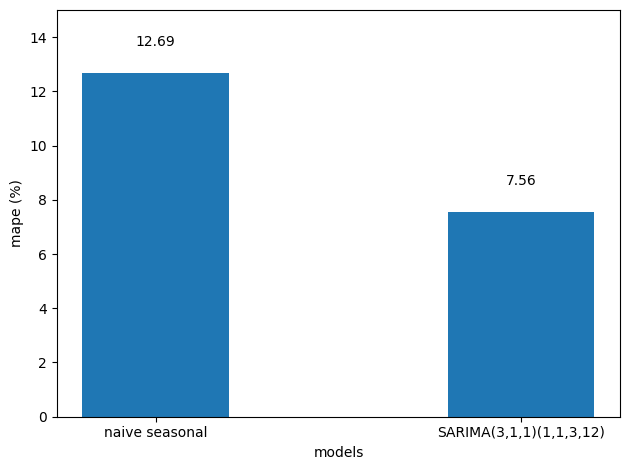

In [48]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(3,1,1)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x,y, width=0.4)
ax.set_xlabel('models')
ax.set_ylabel('mape (%)')
ax.set_ylim(0,15)

for index, value in enumerate(y):
    plt.text(x=index, y=value+1, s=str(round(value,2)), ha='center')

plt.tight_layout()